In [51]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
# Carregar os dados
dados = pd.read_parquet("dataset_com_clusters.parquet")
dados.columns


Index(['id', 'title', 'vote_average', 'vote_count', 'status', 'release_date',
       'revenue', 'runtime', 'adult', 'backdrop_path', 'budget', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'tagline', 'genres',
       'production_companies', 'production_countries', 'spoken_languages',
       'keywords', 'cluster', 'clusters_n'],
      dtype='object')

In [52]:
import pandas as pd

def processar_dados(caminho_arquivo):
    # Carregar os dados
    dados = pd.read_parquet(caminho_arquivo)

    # Selecionar colunas relevantes
    dados = dados[["release_date", "revenue", "budget", "runtime", "genres", 
                  "original_language", "production_countries", "spoken_languages", "adult", "cluster", "clusters_n"]]

    # Filtrar dados (adult == False)
    dados = dados[dados["adult"] == False].copy()

    # Criar coluna 'disponibilidade_lucro'
    dados["disponibilidade_lucro"] = (
        dados["revenue"].apply(lambda x: isinstance(x, (int, float)) and x > 0) & 
        dados["budget"].apply(lambda x: isinstance(x, (int, float)) and x > 0)
    ).astype(int)

    # Eliminar registros com 'disponibilidade_lucro' igual a 0
    dados = dados[dados["disponibilidade_lucro"] == 1].copy()

    # Calcular 'lucro' e 'classificacao'
    dados['lucro'] = dados.apply(lambda row: row['revenue'] - row['budget']
                                 if isinstance(row['budget'], (int, float)) and isinstance(row['revenue'], (int, float))
                                 else None, axis=1)

    dados['classificacao'] = dados.apply(lambda row: 1 if row['lucro'] is not None and row['lucro'] > 0 and row['disponibilidade_lucro'] == 1 else 0, axis=1)

    # Criar o dataset 'dados_com_lucro' (classificacao == 1)
    dados_com_lucro = dados[dados['classificacao'] == 1]

    # Criar o dataset 'dados_sem_lucro' (classificacao == 0)
    dados_sem_lucro = dados[dados['classificacao'] == 0]

    # Criar duas amostras representativas de 'dados_com_lucro' (50% cada)
    metade_lucro_1 = dados_com_lucro.sample(frac=0.5, random_state=42)
    metade_lucro_2 = dados_com_lucro.drop(metade_lucro_1.index)  # O restante dos dados

    # Criar duas amostras representativas de 'dados_sem_lucro' (50% cada)
    metade_sem_lucro_1 = dados_sem_lucro.sample(frac=0.5, random_state=42)
    metade_sem_lucro_2 = dados_sem_lucro.drop(metade_sem_lucro_1.index)  # O restante dos dados

    # Concatenar as metades sem lucro com suas respectivas metades com lucro
    conjunto_1 = pd.concat([metade_lucro_1, metade_sem_lucro_1], ignore_index=True)
    conjunto_2 = pd.concat([metade_lucro_2, metade_sem_lucro_2], ignore_index=True)
    
    return conjunto_1, conjunto_2

def balancear_dados(dados_teste_balanceado, dados_treino_balanceado):
    """
    Balanceia os dados de teste para que a coluna 'classificacao' tenha 80% de 0s e 20% de 1s.
    """

    # Separar os dados de teste em classes 0 e 1
    classe_0 = dados_teste_balanceado[dados_teste_balanceado['classificacao'] == 0]
    classe_1 = dados_teste_balanceado[dados_teste_balanceado['classificacao'] == 1]

    # Calcular o número desejado de amostras para cada classe
    total_amostras = len(dados_teste_balanceado)
    num_classe_0 = int(total_amostras * 0.8)
    num_classe_1 = total_amostras - num_classe_0

    # Subamostrar a classe majoritária (classe 0)
    classe_0_subamostrada = classe_0.sample(n=num_classe_0, random_state=42)

    # Subamostrar a classe minoritária (classe 1)
    classe_1_subamostrada = classe_1.sample(n=num_classe_1, random_state=42)

    # Concatenar as amostras subamostradas
    dados_teste_balanceado = pd.concat([classe_0_subamostrada, classe_1_subamostrada], ignore_index=True)

    return dados_teste_balanceado, dados_treino_balanceado

# Exemplo de uso
dados_teste_balanceado, dados_treino_balanceado = processar_dados("dataset_com_clusters.parquet")

# Verificar o balanceamento
print(dados_teste_balanceado['classificacao'].value_counts(normalize=True))
print(dados_teste_balanceado['classificacao'].value_counts())

# Verificar o balanceamento
print(dados_treino_balanceado['classificacao'].value_counts(normalize=True))
print(dados_treino_balanceado['classificacao'].value_counts())


classificacao
1    0.64236
0    0.35764
Name: proportion, dtype: float64
classificacao
1    3506
0    1952
Name: count, dtype: int64
classificacao
1    0.642294
0    0.357706
Name: proportion, dtype: float64
classificacao
1    3505
0    1952
Name: count, dtype: int64


In [53]:

dados_teste = dados_teste_balanceado.copy()

dados_treino_filtrado = dados_treino_balanceado.copy()
# Criar novas colunas (número de idiomas e idade)
for df in [dados_treino_filtrado, dados_teste]:
    df["num_languages"] = df["spoken_languages"].apply(lambda x: len(x.split(",")) if isinstance(x, str) else 0)
    df["idade"] = df["release_date"].apply(lambda x: 2025 - int(x.split("-")[0]) if isinstance(x, str) else 0)

# Lista de gêneros
generos = ['Action', 'Science Fiction', 'Adventure', 'Drama', 'Crime',
           'Thriller', 'Fantasy', 'Comedy', 'Romance', 'Western', 'Mystery', 'War',
           'Animation', 'Family', 'Horror', 'Music']

def aplicar_one_hot_encoding_generos(df, generos):
    for genero in generos:
        df[genero] = df['genres'].apply(lambda x: 1 if isinstance(x, str) and genero in x.split(', ') else 0)
    return df

# Aplicar one-hot encoding de gêneros
dados_treino_filtrado = aplicar_one_hot_encoding_generos(dados_treino_filtrado, generos)
dados_teste = aplicar_one_hot_encoding_generos(dados_teste, generos)

def aplicar_one_hot_encoding_limitado(df, idiomas_permitidos, selected_countries):
    df['original_language_encoded'] = df['original_language']
    df['production_countries_encoded'] = df['production_countries']
    df['original_language_encoded'] = df['original_language_encoded'].apply(
        lambda x: x if x in idiomas_permitidos else 'other_language'
    )
    df['production_countries_encoded'] = df['production_countries_encoded'].apply(
        lambda x: x if x in selected_countries else 'other_country'
    )
    df = pd.get_dummies(df, columns=['original_language_encoded', 'production_countries_encoded'], prefix=['lang', 'country'])
    return df

# Listas de idiomas e países permitidos
idiomas_permitidos = ['en', 'fr', 'es', 'de', 'ja', 'zh', "pt", 'it']
selected_countries = ['United States', 'France', 'United Kingdom', 'Germany', 
                      'Canada', 'Japan', 'China', 'India', 'Italy', 'Spain']

# Aplicar one-hot encoding limitado
dados_treino_encoded = aplicar_one_hot_encoding_limitado(dados_treino_filtrado, idiomas_permitidos, selected_countries)
dados_teste_encoded = aplicar_one_hot_encoding_limitado(dados_teste, idiomas_permitidos, selected_countries)

# Garantir que a coluna 'genres' seja preservada
dados_treino_encoded['genres'] = dados_treino_filtrado['genres']
dados_teste_encoded['genres'] = dados_teste['genres']

# Alinhar colunas
dados_treino_encoded, dados_teste_encoded = dados_treino_encoded.align(dados_teste_encoded, join='outer', axis=1, fill_value=0)

dados_treino_encoded.to_parquet("dados_treino.parquet", index=False)
dados_teste_encoded.to_parquet("dados_teste.parquet", index=False)


In [54]:
# Lista de colunas a serem removidas
colunas_para_remover = ["release_date", "revenue", "budget", "genres", "original_language", 
                        "production_countries", "spoken_languages", "adult", 
                        "disponibilidade_lucro", "lucro", "runtime", "idade"]

# Aplicar a remoção corretamente
for i, df in enumerate([dados_teste_encoded, dados_treino_encoded]):
    df = df.drop(columns=colunas_para_remover, errors='ignore')

    # Atribuir de volta ao DataFrame correto
    if i == 0:
        dados_teste_encoded = df
    else:
        dados_treino_encoded = df


dados_teste_encoded.columns

Index(['cluster', 'clusters_n', 'classificacao', 'num_languages', 'Action',
       'Science Fiction', 'Adventure', 'Drama', 'Crime', 'Thriller', 'Fantasy',
       'Comedy', 'Romance', 'Western', 'Mystery', 'War', 'Animation', 'Family',
       'Horror', 'Music', 'lang_de', 'lang_en', 'lang_es', 'lang_fr',
       'lang_it', 'lang_ja', 'lang_other_language', 'lang_pt', 'lang_zh',
       'country_Canada', 'country_China', 'country_France', 'country_Germany',
       'country_India', 'country_Italy', 'country_Japan', 'country_Spain',
       'country_United Kingdom', 'country_other_country'],
      dtype='object')

In [55]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Supondo que 'dados_treino_encoded' e 'dados_teste_encoded' já estejam carregados

# Verificar o balanceamento inicial
print("Balanceamento inicial de dados_teste_encoded:")
print(dados_teste_encoded['classificacao'].value_counts(normalize=True))
print(dados_teste_encoded['classificacao'].value_counts())

print("\nBalanceamento inicial de dados_treino_encoded:")
print(dados_treino_encoded['classificacao'].value_counts(normalize=True))
print(dados_treino_encoded['classificacao'].value_counts())

# Isolar registros com classificação 1
registros_classe_1 = dados_treino_encoded[dados_treino_encoded['classificacao'] == 1].copy()

# Remover registros com classificação 1 de dados_treino_encoded
dados_treino_encoded = dados_treino_encoded[dados_treino_encoded['classificacao'] == 0].copy()

# Obter um sample representativo de metade dos registros da classe 1
sample_classe_1 = registros_classe_1.sample(frac=0.5, random_state=42)

# Adicionar o sample de volta a dados_treino_encoded
dados_treino_encoded = pd.concat([dados_treino_encoded, sample_classe_1], ignore_index=True)

# Verificar o balanceamento após as operações
print("\nBalanceamento de dados_treino_encoded após isolar e amostrar:")
print(dados_treino_encoded['classificacao'].value_counts(normalize=True))
print(dados_treino_encoded['classificacao'].value_counts())

Balanceamento inicial de dados_teste_encoded:
classificacao
1    0.64236
0    0.35764
Name: proportion, dtype: float64
classificacao
1    3506
0    1952
Name: count, dtype: int64

Balanceamento inicial de dados_treino_encoded:
classificacao
1    0.642294
0    0.357706
Name: proportion, dtype: float64
classificacao
1    3505
0    1952
Name: count, dtype: int64

Balanceamento de dados_treino_encoded após isolar e amostrar:
classificacao
0    0.526998
1    0.473002
Name: proportion, dtype: float64
classificacao
0    1952
1    1752
Name: count, dtype: int64


In [56]:
import pandas as pd

# Supondo que 'dados_teste_encoded' já esteja carregado

# Verificar o balanceamento inicial de teste
print("Balanceamento inicial de dados_teste_encoded:")
print(dados_teste_encoded['classificacao'].value_counts(normalize=True))
print(dados_teste_encoded['classificacao'].value_counts())

# Isolar registros com classificação 1 em teste
registros_classe_1_teste = dados_teste_encoded[dados_teste_encoded['classificacao'] == 1].copy()

# Remover registros com classificação 1 de dados_teste_encoded
dados_teste_encoded = dados_teste_encoded[dados_teste_encoded['classificacao'] == 0].copy()

# Obter um sample representativo de 25% dos registros da classe 1 em teste
sample_classe_1_teste = registros_classe_1_teste.sample(frac=0.40, random_state=42)

# Adicionar o sample de volta a dados_teste_encoded
dados_teste_encoded = pd.concat([dados_teste_encoded, sample_classe_1_teste], ignore_index=True)

# Verificar o balanceamento após as operações em teste
print("\nBalanceamento de dados_teste_encoded após isolar e amostrar (25%):")
print(dados_teste_encoded['classificacao'].value_counts(normalize=True))
print(dados_teste_encoded['classificacao'].value_counts())

Balanceamento inicial de dados_teste_encoded:
classificacao
1    0.64236
0    0.35764
Name: proportion, dtype: float64
classificacao
1    3506
0    1952
Name: count, dtype: int64

Balanceamento de dados_teste_encoded após isolar e amostrar (25%):
classificacao
0    0.581992
1    0.418008
Name: proportion, dtype: float64
classificacao
0    1952
1    1402
Name: count, dtype: int64


In [57]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import pandas as pd

# Separando features (X) e target (y)
X_train = dados_treino_encoded.drop(columns=['classificacao'])
y_train = dados_treino_encoded['classificacao']

X_test = dados_teste_encoded.drop(columns=['classificacao'])
y_test = dados_teste_encoded['classificacao']

# Criando e treinando o modelo SVM
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')  # Kernel RBF padrão
svm_model.fit(X_train, y_train)

# Fazendo previsões
y_train_pred = svm_model.predict(X_train)
y_test_pred = svm_model.predict(X_test)

# Printando o classification report
print("Classification Report para Treino (SVM):")
print(classification_report(y_train, y_train_pred))

print("\nClassification Report para Teste (SVM):")
print(classification_report(y_test, y_test_pred))

Classification Report para Treino (SVM):
              precision    recall  f1-score   support

           0       0.62      0.84      0.71      1952
           1       0.70      0.42      0.52      1752

    accuracy                           0.64      3704
   macro avg       0.66      0.63      0.62      3704
weighted avg       0.66      0.64      0.62      3704


Classification Report para Teste (SVM):
              precision    recall  f1-score   support

           0       0.66      0.82      0.73      1952
           1       0.61      0.40      0.49      1402

    accuracy                           0.64      3354
   macro avg       0.63      0.61      0.61      3354
weighted avg       0.64      0.64      0.63      3354



Using 185 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Classification Report para Treino (SVM com sample de 1%):
              precision    recall  f1-score   support

           0       0.66      0.94      0.77        93
           1       0.89      0.51      0.65        92

    accuracy                           0.72       185
   macro avg       0.77      0.72      0.71       185
weighted avg       0.77      0.72      0.71       185


Classification Report para Teste (SVM com sample de 1%):
              precision    recall  f1-score   support

           0       0.63      0.84      0.72      1952
           1       0.60      0.32      0.42      1402

    accuracy                           0.63      3354
   macro avg       0.62      0.58      0.57      3354
weighted avg       0.62      0.63      0.60      3354



100%|██████████| 185/185 [11:21<00:00,  3.68s/it]


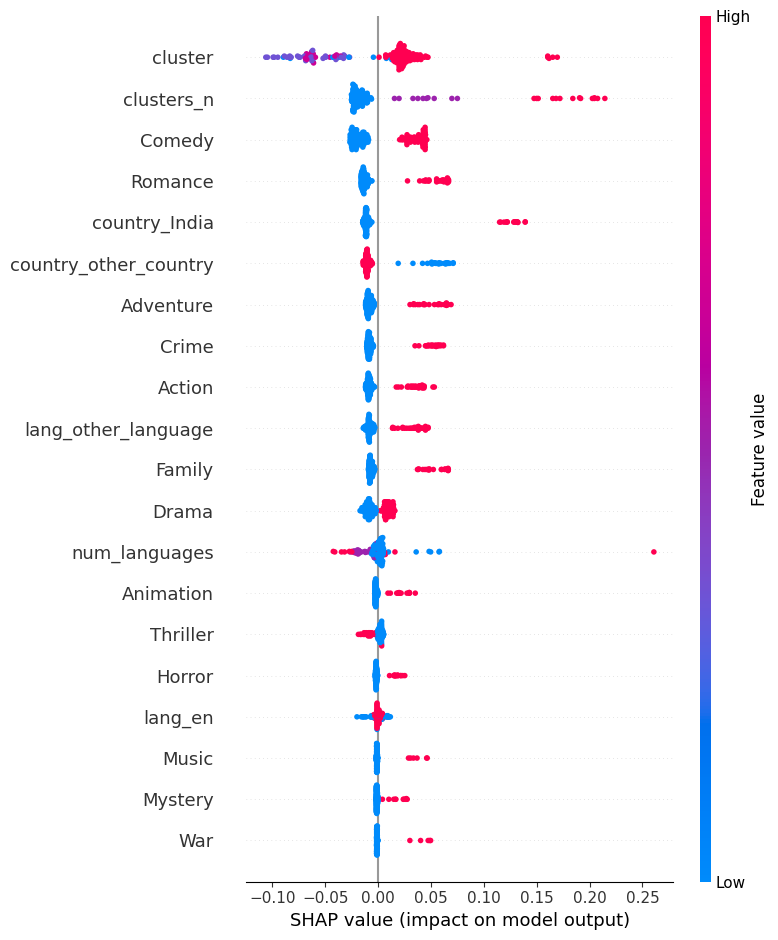

In [58]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import pandas as pd
import shap
from sklearn.model_selection import train_test_split

# Separando features (X) e target (y)
X_train = dados_treino_encoded.drop(columns=['classificacao'])
y_train = dados_treino_encoded['classificacao']

X_test = dados_teste_encoded.drop(columns=['classificacao'])
y_test = dados_teste_encoded['classificacao']

# Criando um sample representativo de 1% dos dados de treino
X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, train_size=0.05, random_state=42)

# Criando e treinando o modelo SVM com o sample
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
svm_model.fit(X_train_sample, y_train_sample)

# Fazendo previsões com o sample
y_train_pred = svm_model.predict(X_train_sample)
y_test_pred = svm_model.predict(X_test)

# Printando o classification report
print("Classification Report para Treino (SVM com sample de 1%):")
print(classification_report(y_train_sample, y_train_pred))

print("\nClassification Report para Teste (SVM com sample de 1%):")
print(classification_report(y_test, y_test_pred))

# Aplicando o SHAP para explicar o modelo com o sample
explainer = shap.KernelExplainer(svm_model.predict_proba, X_train_sample)
shap_values = explainer.shap_values(X_train_sample)

# Selecionando os SHAP values para a classe positiva (classe 1)
shap_values_class_1 = shap_values[1]  # A classe 1 é geralmente a classe positiva

# Visualizando as importâncias das features com beeswarm plot
shap.summary_plot(shap_values_class_1, X_train_sample, feature_names=X_train_sample.columns, plot_type="dot")  # plot_type="dot" para beeswarm
